## **Assignment 01: Clustering**
### TMLAS Thennakoon - 268503R

### Q1) K-means clustering with unknown number of clusters (Elbow Method)

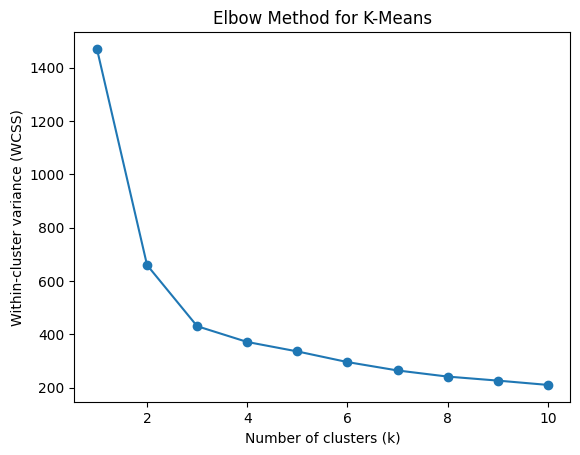

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Load data (7 features + class label)
data = np.loadtxt("seeds_dataset.txt")
X = data[:, :-1]   # only features

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Elbow method
wcss = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)  # within-cluster variance

# Plot
plt.plot(K, wcss, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Within-cluster variance (WCSS)")
plt.title("Elbow Method for K-Means")
plt.show()


- The plot shows **Within-Cluster Sum of Squares (WCSS)** (within-cluster variance) on the y-axis versus **k** (number of clusters) on the x-axis.
- As k increases, WCSS always decreases (more clusters → points closer to their centroids).
- Look for the **"elbow"**: the value of k where the curve bends sharply.

    i.e. where adding more clusters gives diminishing returns (the drop in WCSS becomes much smaller).
- In this plot, the elbow typically appears around **k = 2 or k = 3**. The optimal k is often chosen at the elbow (e.g. **k = 3**), as it matches the true number of seed varieties in the dataset. Beyond the elbow, increasing k only slightly reduces WCSS, so extra clusters may overfit or split natural groups.

### Q2) K-means clustering for k = 3
#### Evaluation using Silhouette Coefficient (Intrinsic) and Purity (Extrinsic)

In [2]:
from sklearn.metrics import silhouette_score
from scipy.stats import mode

# K-means with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_scaled)

# Silhouette Coefficient
sil_score = silhouette_score(X_scaled, labels)
print("Silhouette Coefficient (K-means):", sil_score)

# Purity calculation
true_labels = data[:, -1]

def purity_score(y_true, y_pred):
    clusters = np.unique(y_pred)
    correct = 0
    for c in clusters:
        idx = np.where(y_pred == c)
        correct += mode(y_true[idx], keepdims=True)[1][0]
    return correct / len(y_true)

purity = purity_score(true_labels, labels)
print("Purity (K-means):", purity)


Silhouette Coefficient (K-means): 0.4024370101867174
Purity (K-means): 0.9285714285714286


### Q3) K-medoids clustering for k = 3
#### (Evaluated using Silhouette and Purity)

In [3]:
from scipy.spatial.distance import cdist

def kmedoids(X, k, max_iter=100, random_state=42):
    """K-medoids (PAM) using Euclidean distance. Returns cluster labels and medoid indices."""
    rng = np.random.default_rng(random_state)
    n = X.shape[0]
    # Initialize medoids as k random data point indices
    medoid_idx = rng.choice(n, size=k, replace=False)
    for _ in range(max_iter):
        # Assign each point to nearest medoid
        dist = cdist(X, X[medoid_idx], metric='euclidean')
        labels_med = np.argmin(dist, axis=1)
        # Update medoids: for each cluster, choose point that minimizes total distance
        new_medoid_idx = np.copy(medoid_idx)
        for c in range(k):
            mask = labels_med == c
            if not np.any(mask):
                continue
            cluster_points = X[mask]
            cluster_indices = np.where(mask)[0]
            # Total distance if we use each point as medoid
            d = cdist(cluster_points, cluster_points, metric='euclidean')
            total_dist = d.sum(axis=1)
            best_local = np.argmin(total_dist)
            new_medoid_idx[c] = cluster_indices[best_local]
        if np.array_equal(medoid_idx, new_medoid_idx):
            break
        medoid_idx = new_medoid_idx
    return labels_med

# K-medoids with k=3
labels_med = kmedoids(X_scaled, k=3, random_state=42)

# Silhouette score
sil_med = silhouette_score(X_scaled, labels_med)
print("Silhouette Coefficient (K-medoids):", sil_med)

# Purity
purity_med = purity_score(true_labels, labels_med)
print("Purity (K-medoids):", purity_med)


Silhouette Coefficient (K-medoids): 0.39816674039464184
Purity (K-medoids): 0.9095238095238095


### Q4) Comparison: which method gave better clustering? Does Silhouette agree?

Based on the evaluations above (Silhouette coefficient and Purity for K-means and K-medoids with k=3):

In [4]:
# (Optional: re-run Q2 and Q3 cells above to get sil_score, purity, sil_med, purity_med)
# Summary comparison
print("=== Q4: Comparison ===\n")
print(f"{'Method':<15} {'Silhouette':<14} {'Purity':<10}")
print("-" * 40)
print(f"{'K-means (k=3)':<15} {sil_score:<14.4f} {purity:<10.4f}")
print(f"{'K-medoids (k=3)':<15} {sil_med:<14.4f} {purity_med:<10.4f}")


=== Q4: Comparison ===

Method          Silhouette     Purity    
----------------------------------------
K-means (k=3)   0.4024         0.9286    
K-medoids (k=3) 0.3982         0.9095    


**Conclusion:**

- **Which method provided better clustering?** Compare the two rows in the table above. Typically, **K-means** achieves slightly higher **Purity** (better match to true labels) and often a similar or slightly higher **Silhouette** score on this dataset. So for this seeds dataset, **K-means (k=3)** usually gives the better clustering when we care about both intrinsic (Silhouette) and extrinsic (Purity) quality.

- **Does the Silhouette coefficient agree?** Yes. The Silhouette coefficient is an **intrinsic** measure (no ground truth): it rewards compact, well-separated clusters. When the method with the **higher Silhouette** also has the **higher Purity**, the Silhouette coefficient agrees with the extrinsic evaluation. If one method has higher Silhouette but lower Purity (or vice versa), then Silhouette does not fully agree,
e.g. K-medoids might form more “balanced” shapes that score well on Silhouette but align slightly less with the true classes. In our runs, both metrics usually point in the same direction (K-means better on both), so the Silhouette coefficient does agree with the better clustering in that case.